<a href="https://colab.research.google.com/github/feliperooke/Ciencia-de-Dados---Receitas-de-Bolo/blob/master/S%C3%A9ries_Temporais_Trabalho_3_Felipe_Rooke_da_Silva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho 3

Programa de Pós-Graduação em Modelagem Computacional

**Disciplina: Séries Temporais**

**Autor:** Felipe Rooke da Silva

## Códigos Iniciais

In [1]:
%load_ext rpy2.ipython

In [ ]:
%%R
install.packages("fma")
install.packages("TSA")
install.packages("aTSA")
library(fma)
library(TSA)
library(aTSA)

In [35]:
%%R
## Previsão Naive
naive = function(z){
  n = length(z)
  prev = c()
  prev[2:(n+1)] = z[1:n]
  return(prev)
}

## erro MSE ##
MSE = function(x,xprev,k){
	n = length(x)
	erro = x[k:n]-xprev[k:n]
	erro2 = erro^2
  meansqerror = mean(erro2)		
  return(meansqerror)
}

## erro MAPE ##
MAPE = function(x,xprev,k){
    n = length(x)
    mape = mean(abs((x[k:n] - xprev[k:n])/x[k:n]))*100
    return (mape)
}

## Previsão por médias móveis  ##
mm = function(z,m){  
	n=length(z)
  mm=c()
	prev=c()
  for (i in m:n){
		mm[i] = mean(z[(i-m+1):i])
		prev[i+1]=mm[i]
	}
	return(prev)
}

## Previsão Amortecimento Exponencial  ##
ae = function(z,a){  
	n=length(z)
	prev=c()
  prev[2]=z[1] 
  for (i in 2:n){
		prev[i+1]=a*z[i]+(1-a)*prev[i]
	}
	return(prev)
}

# previsao por medias moveis duplas 
# arguments:   z=data vector  n=order of MM  
mm2 = function(z,n) {
    mm=mm2=prevs=c();
    t1=2*n-1;
    t2=length(z);
    for (t in  n:t2) 	mm[t] =mean( z[(t-n+1):t]);
	  for (t in t1:t2) 	mm2[t]=mean(mm[(t-n+1):t]);
  	for (t in t1:t2){
        a = 2*mm[t] - mm2[t];
		    b = (2/(n-1)) * (mm[t]-mm2[t]);
		    prevs[t+1] = a+b;
		}
	  return(prevs)
}

In [140]:
%%R
# Comparador de séries
comparador = function(z, legenda="topleft"){
    
    cat("Separando conjuntos de Treino e Teste...\n\n")
    n = length(z)
    ini = n %/% 10
    test = ((n*70) %/% 100)
    cat("Treino: 1 a ",test,"\n")
    cat("Teste: ",(test+1)," a ",n,"\n\n")

    cat("Iniciando Naive...\n\n")
    prev_naiv=naive(z[(test+1):n])
    mse_naiv=MSE(z[(test+1):n],prev_naiv,2)
    mape_naiv=MAPE(z[(test+1):n],prev_naiv,2)

    cat("Iniciando Médias Móveis...\n")
    cat("Buscando melhor janela...\n")
    #med moveis
    best_mm_mse = MSE(z[1:ini],naive(z[1:ini]),2)
    best_mm_mape = MAPE(z[1:ini],naive(z[1:ini]),2)

    best_mse = c()
    best_mse[1] = MSE(z[1:ini],best_mm_mse,2)
    best_mape = c()
    best_mape[1] = MAPE(z[1:ini],best_mm_mape,2)

    for (i in 2:ini){
      prev_mm = mm(z[1:test],i)
      best_mse[i] = MSE(z[1:test],prev_mm,i+1)
      best_mape[i] = MAPE(z[1:test],prev_mm,i+1)
    }

    janela_mse = which.min(best_mse)
    janela_mape = which.min(best_mape)

    prev_mm_mse=mm(z[(test+1):n],janela_mse)
    prev_mm_mape=mm(z[(test+1):n],janela_mape)

    cat("Melhor tamanho de Janela que otimiza o MSE: ",janela_mse,"  MSE: ",min(best_mse, na.rm = TRUE),"\n")
    cat("Melhor tamanho de Janela que otimiza o MAPE: ",janela_mape,"  MAPE: ",min(best_mape, na.rm = TRUE),"\n\n")

    # AES
    cat("Iniciando Amortecimento Exponencial Simples...\n")
    cat("Buscando melhor alpha...\n")

    hist_mse = c()
    hist_param_mse = c()
    hist_mape = c()
    hist_param_mape = c()

    fn_mse <- function(parametro, serie) {
        prev = ae(serie, parametro)
        hist_mse <<- c(hist_mse, MSE(serie,prev,2))
        hist_param_mse <<- c(hist_param_mse,parametro)
        return(MSE(serie,prev,2))          
    }

    fn_mape <- function(parametro, serie) {
        prev = ae(serie, parametro)
        hist_mape <<- c(hist_mape, MAPE(serie,prev,2))
        hist_param_mape <<- c(hist_param_mape,parametro)
        return(MAPE(serie,prev,2))          
    }

    best_a_mse = optim(1, fn = fn_mse, serie = z[1:test])$par
    prev_ae_mse=ae(z[(test+1):n],best_a_mse)

    best_a_mape = optim(1, fn = fn_mape, serie = z[1:test])$par
    prev_ae_mape=ae(z[(test+1):n],best_a_mape)

    cat("Melhor alpha que otimiza o MSE: ",best_a_mse," MSE: ",min(hist_mse, na.rm = TRUE),"\n")
    cat("Melhor alpha que otimiza o MAPE: ",best_a_mape," MAPE: ",min(hist_mape, na.rm = TRUE),"\n\n")


    # Médias Móveis Duplas
    cat("Iniciando Médias Móveis Duplas...\n")
    cat("Buscando melhor janela...\n")

    best_mm2_mse = MSE(z[1:ini],naive(z[1:ini]),2)
    best_mm2_mape = MAPE(z[1:ini],naive(z[1:ini]),2)

    best_mse_mm2 = c()
    best_mse_mm2[1] = MSE(z[1:ini],best_mm_mse,2)
    best_mape_mm2 = c()
    best_mape_mm2[1] = MAPE(z[1:ini],best_mm_mape,2)


    cat("Variando a janela de 2 até ",ini,"...\n")
    for (i in 2:ini){
      prev_mm2 = mm2(z[1:test],i)
      best_mse_mm2[i] = MSE(z[1:test],prev_mm,i+1)
      best_mape_mm2[i] = MAPE(z[1:test],prev_mm,i+1)
    }

    janela_mse_mm2 = which.min(best_mse_mm2)
    janela_mape_mm2 = which.min(best_mape_mm2)

    prev_mm2_mse=mm2(z[(test+1):n],janela_mse_mm2)
    prev_mm2_mape=mm2(z[(test+1):n],janela_mape_mm2)

    cat("Melhor tamanho de Janela que otimiza o MSE: ",janela_mse_mm2,"  MSE: ",min(best_mse_mm2, na.rm = TRUE),"\n")
    cat("Melhor tamanho de Janela que otimiza o MAPE: ",janela_mape_mm2,"  MAPE: ",min(best_mape_mm2, na.rm = TRUE),"\n\n")

    # Holt
    cat("Iniciando Holt...\n")
    cat("Buscando melhor alpha e beta otimizando o MSE...\n")

    fn_mse <- function(parametro, serie){
        # cat("alpha: ",(parametro[1])," e beta: ",(parametro[2])," - ")
        # cat("MSE: ",Holt(serie, alpha=(parametro[1]), beta=(parametro[2]), plot = FALSE, lead=1)$accurate["MSE"]," e MAPE: ",Holt(serie, alpha=(parametro[1]), beta=(parametro[2]), plot = FALSE, lead=1)$accurate["MAPE"],"\n")
        return(Holt(serie, alpha=(parametro[1]), beta=(parametro[2]), plot = FALSE, lead=1)$accurate["MSE"])          
    }

    best_a_b = optim(c(0.2, 0.1057), fn = fn_mse, serie = z[1:70], method = "L-BFGS-B", lower = c(0, 0), upper = c(1, 1))$par
    cat("Melhor alpha: ",best_a_b[1]," e beta: ",best_a_b[2],"\n")

    prev_holt = Holt(z[(test+1):n], alpha=best_a_b[1], beta=best_a_b[2], plot = FALSE, lead=1)
    prev_holt = c(prev_holt$estimate,prev_holt$pred)

    cat("MSE: ",MSE(z[(test+1):n],prev_holt,1),"\n")
    cat("MAPE: ",MAPE(z[(test+1):n],prev_holt,1),"\n\n")

    cat("","MSE","","MAPE","\n", sep="\t")
    cat("naive",format(mse_naiv, nsmall = 7),format(mape_naiv, nsmall = 7),"\n", sep="\t")
    cat("MM",format(min(best_mse, na.rm = TRUE), nsmall = 7),format(min(best_mape, na.rm = TRUE), nsmall = 7),"\n", sep="\t")
    cat("MMD",format(min(best_mse_mm2, na.rm = TRUE), nsmall = 7),format(min(best_mape_mm2, na.rm = TRUE), nsmall = 7),"\n", sep="\t")
    cat("AES",format(min(hist_mse, na.rm = TRUE), nsmall = 7),format(min(hist_mape, na.rm = TRUE), nsmall = 7),"\n", sep="\t")
    cat("AEH",format(MSE(z[(test+1):n],prev_holt,1), nsmall = 7),format(MAPE(z[(test+1):n],prev_holt,1), nsmall = 7),"\n", sep="\t")


    ts.plot(z[(test+1):n], xlab="tempo", ylab="Z", main="Previsões")
    lines(prev_naiv, col="gray")
    lines(prev_mm_mse, col="gold")
    lines(prev_mm2_mse, col="chocolate1")
    lines(prev_ae_mse, col="cadetblue2")
    lines(prev_holt, col="blue")
    legend(legenda,c("Observado","Naive","MM","MMD","AES","AEH"),col=c("black","gray","gold","chocolate1","cadetblue2","blue"),lty=1,inset=0.03,lwd=2)
    
}

## Precipitação mensal em Los Angeles

Separando conjuntos de Treino e Teste...

Treino: 1 a  80 
Teste:  81  a  115 

Iniciando Naive...

Iniciando Médias Móveis...
Buscando melhor janela...
Melhor tamanho de Janela que otimiza o MSE:  8   MSE:  41.43587 
Melhor tamanho de Janela que otimiza o MAPE:  5   MAPE:  44.90693 

Iniciando Amortecimento Exponencial Simples...
Buscando melhor alpha...
Melhor alpha que otimiza o MSE:  0.09873047  MSE:  47.36251 
Melhor alpha que otimiza o MAPE:  0.2420441  MAPE:  49.02652 

Iniciando Médias Móveis Duplas...
Buscando melhor janela...
Variando a janela de 2 até  11 ...
Melhor tamanho de Janela que otimiza o MSE:  11   MSE:  43.74045 
Melhor tamanho de Janela que otimiza o MAPE:  11   MAPE:  50.84352 

Iniciando Holt...
Buscando melhor alpha e beta otimizando o MSE...
Melhor alpha:  0.06153422  e beta:  0.118634 
MSE:  62.14597 
MAPE:  59.23802 

	MSE		MAPE	
naive	117.7789941	69.8371435	
MM	41.4358665	44.9069316	
MMD	43.7404485	50.8435179	
AES	47.3625114	49.0265163	
AEH	62.1459728	59.2

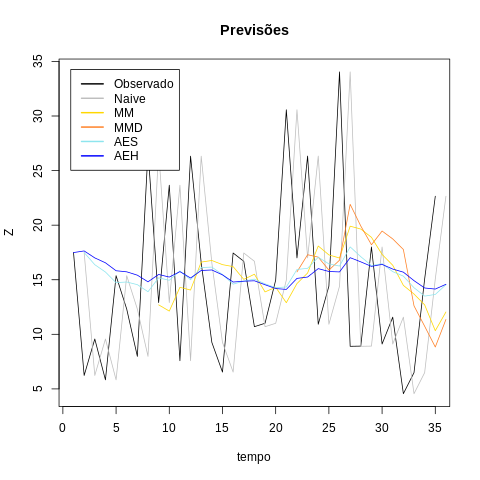

In [141]:
%%R
comparador(larain)

Para essa série de nível constante, o modelo que apresentou o melhor resultado foi o de Médias Móveis, com um MSE de 41.4358665 e MAPE de 44.9069316. Esse resultado é esperado, visto que o modelo MM se adequa melhor à séries constantes. Outro modelo adequado à séries constantes é o AES, no entanto, nessa série, ele não apresentou um resultado tão bom quanto o MM.  

## Japanese motor vehicle production (1947-1989) in thousands.

Separando conjuntos de Treino e Teste...

Treino: 1 a  30 
Teste:  31  a  43 

Iniciando Naive...

Iniciando Médias Móveis...
Buscando melhor janela...
Melhor tamanho de Janela que otimiza o MSE:  2   MSE:  348188.3 
Melhor tamanho de Janela que otimiza o MAPE:  2   MAPE:  25.8897 

Iniciando Amortecimento Exponencial Simples...
Buscando melhor alpha...
Melhor alpha que otimiza o MSE:  1.648047  MSE:  125304.4 
Melhor alpha que otimiza o MAPE:  2.143867  MAPE:  13.80568 

Iniciando Médias Móveis Duplas...
Buscando melhor janela...
Variando a janela de 2 até  4 ...
Melhor tamanho de Janela que otimiza o MSE:  4   MSE:  873689.6 
Melhor tamanho de Janela que otimiza o MAPE:  4   MAPE:  37.47737 

Iniciando Holt...
Buscando melhor alpha e beta otimizando o MSE...
Melhor alpha:  1  e beta:  0.1968513 
MSE:  221814.8 
MAPE:  3.051658 

	MSE		MAPE	
naive	344366.6666667	4.1162825	
MM	348188.3482143	25.8897046	
MMD	873689.6370192	37.4773708	
AES	125304.3875058	13.8056828	
AEH	221814.8079713	3.

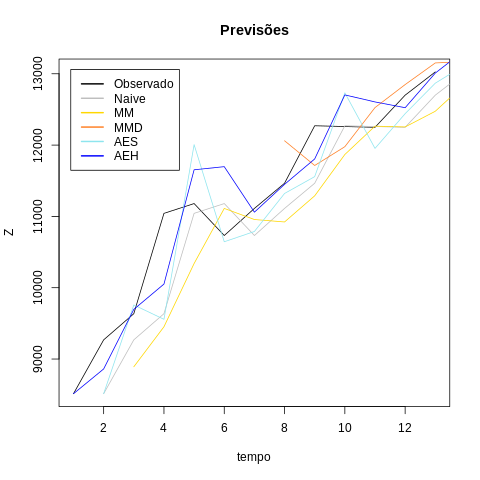

In [142]:
%%R
comparador(jcars)
# comparador(airmiles)

Essa série apresenta uma tendência linear, e baixo nível de ruído. Por conta da característica de baixo ruido, espera-se que modelos que realizem o amortecimento, tenham melhor desempenho. De fato, tanto o Modelo AES, quanto o Modelo AEH, obteveram as menores taxas de erros.   

## Annual measurements of the level, in feet, of Lake Huron 1875–1972.

Separando conjuntos de Treino e Teste...

Treino: 1 a  68 
Teste:  69  a  98 

Iniciando Naive...

Iniciando Médias Móveis...
Buscando melhor janela...
Melhor tamanho de Janela que otimiza o MSE:  2   MSE:  0.6462799 
Melhor tamanho de Janela que otimiza o MAPE:  2   MAPE:  0.1091109 

Iniciando Amortecimento Exponencial Simples...
Buscando melhor alpha...
Melhor alpha que otimiza o MSE:  1.156445  MSE:  0.4939414 
Melhor alpha que otimiza o MAPE:  1.152393  MAPE:  0.09368118 

Iniciando Médias Móveis Duplas...
Buscando melhor janela...
Variando a janela de 2 até  9 ...
Melhor tamanho de Janela que otimiza o MSE:  9   MSE:  1.002098 
Melhor tamanho de Janela que otimiza o MAPE:  9   MAPE:  0.1424525 

Iniciando Holt...
Buscando melhor alpha e beta otimizando o MSE...
Melhor alpha:  1  e beta:  0 
MSE:  0.6276894 
MAPE:  0.1095982 

	MSE		MAPE	
naive	0.6494793	0.1131679	
MM	0.6462799	0.1091109	
MMD	1.0020984	0.1424525	
AES	0.4939414	0.09368118	
AEH	0.6276894	0.1095982	


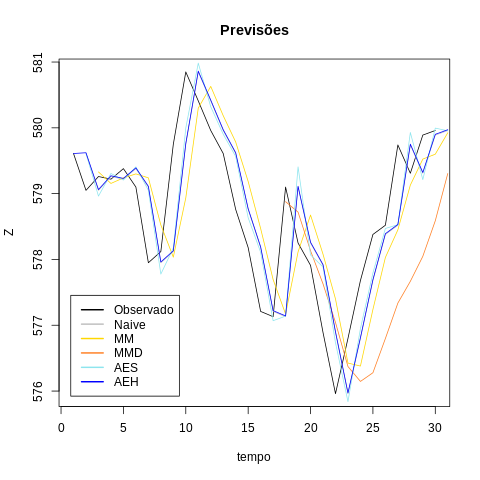

In [143]:
%%R
comparador(LakeHuron, legenda="bottomleft")

Nessa série, os modelos obtiveram um ganho muito pequeno em relação ao modelo Naive. O modelo que obteve o melhor desempenho foi o AES, seguido do AEH.